# Practical HW 3: Sounds of Seattle Birds
**Nicole Nagata**

https://github.com/nicolenagata/DATA5321_HW3

## Overview
This homework will use neural networks to identify the sounds of birds common in the Seattle area.

You must build your own, custom* neural network to predict species based on sounds. You should have comparisons between multiple network structures/hyperparameters to show that you made a concerted effort to get the best possible results, even if your network performs poorly. You are welcome and encouraged to show additional examples of pretrained models as comparisons to your own, but you must create each of the following on your own:

- **Binary Model**: Pick two bird species and build a network to do binary classification on these two alone.
- **Multi-class Model**: Build a neural network to classify between all 12 bird species.
- **External Test Data**: Each of 3 test clips provided are of raw sound data (mp3), some of which contain more than one bird call. Convert them using the methodology described below, and use your 12-species network to predict which birds are calling-- clearly state your prediction of each of the three clips in a table in your results section. Which clips do you think contain more than one bird and why? Make sure to justify your reasoning with a plot or data.

## Importing Data

In [95]:
### Import data
import h5py
import numpy as np

# Specify file path
file_path = r"C:\Users\nnaga\Downloads\bird_spectrograms.hdf5"

# Open the file
f = h5py.File(file_path, 'r')

# Print keys (12 species)
print(list(f.keys()))  

['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']


In [96]:
### Match each spectrogram to a label

# Access a specific dataset using the species key (replace with actual key)
species_key = 'amecro'  # Example, replace with a valid key from the printed list
dset = f[species_key]

# Print the shape of the dataset
print(dset.shape)  # Should be (128, 517, #samples btwn 37-630)

(128, 517, 66)


In [97]:
### Exploring Class Imbalance
import pandas as pd
# List of keys
species_keys = ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin',
                'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']

# Count samples per species
sample_counts = {key: f[key].shape[2] for key in species_keys}

# Create DataFrame
df_counts = pd.DataFrame(list(sample_counts.items()), columns=['Species', 'Num_Samples'])
df_counts = df_counts.sort_values(by='Num_Samples', ascending=False)

# Print DataFrame
print(df_counts)

   Species  Num_Samples
6   houspa          630
9   sonspa          263
8   rewbla          187
1   amerob          172
2   bewwre          144
10  spotow          137
4   daejun          125
11  whcspa           91
5   houfin           84
0   amecro           66
3   bkcchi           45
7   norfli           37


## Binary Classification: American Crow or White-crownned Sparrow

In [98]:
### Train Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Specify file path
file_path = r"C:\Users\nnaga\Downloads\bird_spectrograms.hdf5"

# Open the file
f = h5py.File(file_path, 'r')

# define shape for both species
species1 = 'amecro'
dset1 = f[species1]
print(dset1.shape)

species2 = 'whcspa'
dset2 = f[species2]
print(dset2.shape)

# reorder input for CNN (#samples, 128, 517)
X1 = np.transpose(f[species1][:], (2, 0, 1))
X2 = np.transpose(f[species2][:], (2, 0, 1))

# Create X and Y dfs
X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((np.ones(X1.shape[0]), np.zeros(X2.shape[0])), axis=0)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=13)

# Convert target variable to binary class
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Check final shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(128, 517, 66)
(128, 517, 91)
(105, 128, 517) (105, 1)
(52, 128, 517) (52, 1)


In [100]:
### Define Nerual Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # detects patterns in images
        # 32 filters, 3x3 kernel, ReLU activation, input shape (height, width, channel)
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 517, 1)),
    # reduce dimensionality
    MaxPooling2D(pool_size=(2, 2)),

    # more complex features (increase to 64 filters)
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # converts multi dimensional space to 1D vector
    Flatten(),
    # hidden layer
    Dense(64, activation='relu'),
    # dropout later 50% nodes randomly dropped
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 515, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 257, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 255, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 127, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 243840)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │    15,605,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,624,705 (59.60 MB)

 Trainable params: 15,624,705 (59.60 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
### Compile Neural Network Model
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [102]:
### Train Neural Network Model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4)
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.6189 - loss: 244.2251 - val_accuracy: 0.5238 - val_loss: 7.3486
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.6111 - loss: 13.1129 - val_accuracy: 0.5238 - val_loss: 1.2862
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6348 - loss: 3.1308 - val_accuracy: 0.4762 - val_loss: 28.6090
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.5682 - loss: 15.4854 - val_accuracy: 0.4762 - val_loss: 15.5321
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.6748 - loss: 7.4901 - val_accuracy: 0.8095 - val_loss: 0.4570
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.9658 - loss: 0.1225 - val_accuracy: 0.8571 - val_loss: 0.3002
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.9465 - loss: 0.1149 - val_accuracy: 0.8571 - val_loss: 0.4241
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9851 - loss: 0.0422 - val_accuracy: 0.8571 - val

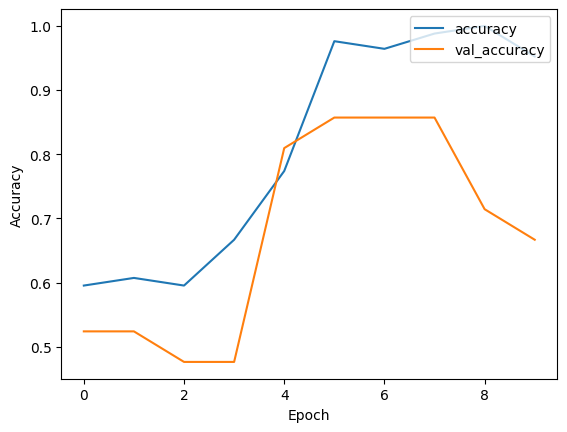

In [103]:
history.history.keys() # to see available metrics
### Plots
import matplotlib.pyplot as plt
# accuracy for training and validation set
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper right')
plt.show();

In [104]:
# evaluate model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.2f}%".format(score[1]*100))

Test Accuracy: 84.62%


In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

# Predict class probabilities on test data
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary class predictions
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm

# Create a DataFrame to display as a table
cm_table = pd.DataFrame(cm, 
                        index=['Actual: Sparrow', 'Actual: American Crow'], 
                        columns=['Predicted: Sparrow', 'Predicted: American Crow'])

print("Confusion Matrix:")
print(cm_table)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Confusion Matrix:
                       Predicted: Sparrow  Predicted: American Crow
Actual: Sparrow                        32                         0
Actual: American Crow                   8                        12


In [106]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)  # assumes American Crow is the positive class (1)
f1 = f1_score(y_test, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8462
Recall: 0.6000
F1 Score: 0.7500


### Multi-class Model: 12 Bird Species

In [4]:
import numpy as np
import h5py

# Specify file path
file_path = r"C:\Users\nnaga\Downloads\bird_spectrograms.hdf5"

# Open the file
f = h5py.File(file_path, 'r')

# Define all species
species_list = ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 
                'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']

# Parameters
samples_per_class = 100  # Target number of samples per class

# Initialize data containers
X = []
y = []

# Loop through species
for i, species in enumerate(species_list):
    dset = f[species]  # shape: (128, 517, N)
    print(f"{species}: original shape {dset.shape}")

    # Load entire dataset and transpose to (N, 128, 517)
    X_species = np.transpose(dset[:], (2, 0, 1))
    available_samples = X_species.shape[0]

    # Sample to fixed number of examples
    if available_samples >= samples_per_class:
        indices = np.random.choice(available_samples, size=samples_per_class, replace=False)
    else:
        indices = np.random.choice(available_samples, size=samples_per_class, replace=True)

    # Apply sampling
    X_species = X_species[indices]

    # Append to dataset
    X.append(X_species)
    y.append(np.full(samples_per_class, i))  # Label as class index

# Convert to final arrays
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
print(f"Final dataset shape: X={X.shape}, y={y.shape}")

# Confirm class counts
from collections import Counter
class_counts = Counter(y)
print("\nSample count per class:")
for i, species in enumerate(species_list):
    print(f"{species} (label {i}): {class_counts[i]} samples")

amecro: original shape (128, 517, 66)
amerob: original shape (128, 517, 172)
bewwre: original shape (128, 517, 144)
bkcchi: original shape (128, 517, 45)
daejun: original shape (128, 517, 125)
houfin: original shape (128, 517, 84)
houspa: original shape (128, 517, 630)
norfli: original shape (128, 517, 37)
rewbla: original shape (128, 517, 187)
sonspa: original shape (128, 517, 263)
spotow: original shape (128, 517, 137)
whcspa: original shape (128, 517, 91)
Final dataset shape: X=(1200, 128, 517), y=(1200,)

Sample count per class:
amecro (label 0): 100 samples
amerob (label 1): 100 samples
bewwre (label 2): 100 samples
bkcchi (label 3): 100 samples
daejun (label 4): 100 samples
houfin (label 5): 100 samples
houspa (label 6): 100 samples
norfli (label 7): 100 samples
rewbla (label 8): 100 samples
sonspa (label 9): 100 samples
spotow (label 10): 100 samples
whcspa (label 11): 100 samples


In [5]:
### Split into Train Test Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# train/test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=13)

# Convert target variable to binary class
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Check final shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(804, 128, 517) (804, 12)
(396, 128, 517) (396, 12)


In [6]:
### Define Multi-Class Neural Netowrk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 517, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')  # Output layer for multi class
])
model.summary()

C:\Users\nnaga\miniconda3\envs\myenvname\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 515, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 257, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 255, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 127, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 243840)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,605,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,625,420 (59.61 MB)

 Trainable params: 15,625,420 (59.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
### Compile Multi-Class Neural Netowrk
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Multi-class loss function
              metrics=['accuracy'])

In [8]:
### Train Multi-Class Neural Network
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.1052 - loss: 41.5180 - val_accuracy: 0.2609 - val_loss: 2.4328
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.3035 - loss: 2.3057 - val_accuracy: 0.2919 - val_loss: 2.2644
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.4878 - loss: 1.6381 - val_accuracy: 0.3665 - val_loss: 1.9874
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.7278 - loss: 0.9949 - val_accuracy: 0.4286 - val_loss: 2.3725
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.8270 - loss: 0.6094 - val_accuracy: 0.3975 - val_loss: 2.3025
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.8628 - loss: 0.5115 - val_accuracy: 0.4286 - val_loss: 2.3007
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 286ms/step - accuracy: 0.9044 - loss: 0.3782 - val_accuracy: 0.4224 - val_loss: 2.2351
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 297ms/step - accuracy: 0.9277 - loss: 0.3064 - val_accur

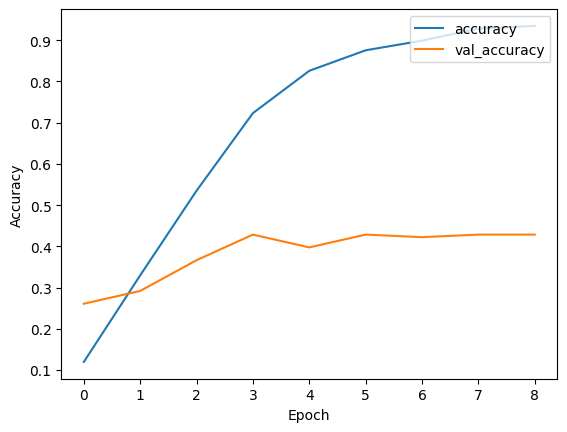

In [9]:
### Plots
# accuracy for training and validation set
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper right')
plt.show();

In [10]:
# evaluate model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.2f}%".format(score[1]*100))

Test Accuracy: 44.44%


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step


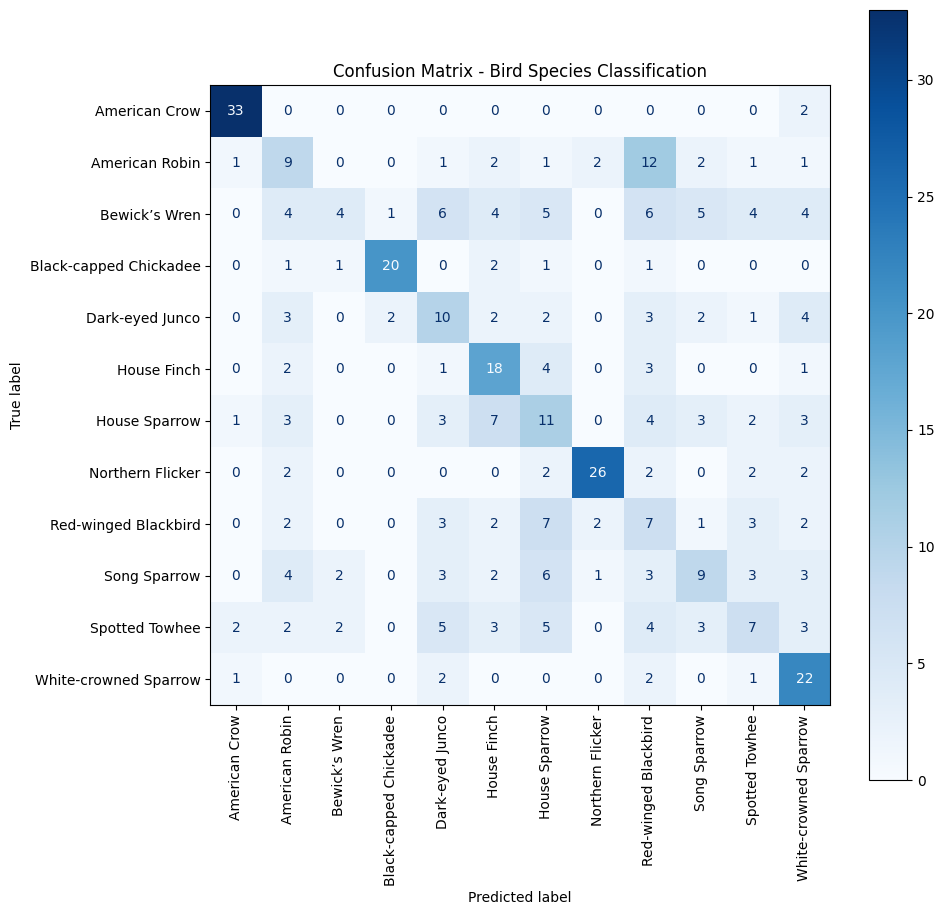

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict probabilities on test set
y_pred_proba = model.predict(X_test)

# Convert one-hot predictions and true labels to integer class labels
y_pred_classes = np.argmax(y_pred_proba, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Define species labels for display
labels = ['American Crow', 'American Robin', 'Bewick’s Wren', 'Black-capped Chickadee',
          'Dark-eyed Junco', 'House Finch', 'House Sparrow', 'Northern Flicker',
          'Red-winged Blackbird', 'Song Sparrow', 'Spotted Towhee', 'White-crowned Sparrow']

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix - Bird Species Classification")
plt.show()

In [12]:
### Accuracy, Recall, F1

import numpy as np

# Predict class probabilities on test data
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert to class labels
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Recall and F1 score averaged across classes
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

# per-class performance metrics
print(classification_report(y_true_classes, y_pred_classes))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Accuracy: 0.4444
Recall (macro): 0.4619
F1 Score (macro): 0.4439
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        35
           1       0.28      0.28      0.28        32
           2       0.44      0.09      0.15        43
           3       0.87      0.77      0.82        26
           4       0.29      0.34      0.32        29
           5       0.43      0.62      0.51        29
           6       0.25      0.30      0.27        37
           7       0.84      0.72      0.78        36
           8       0.15      0.24      0.18        29
           9       0.36      0.25      0.30        36
          10       0.29      0.19      0.23        36
          11       0.47      0.79      0.59        28

    accuracy                           0.44       396
   macro avg       0.46      0.46      0.44       396
weighted avg       0.46      0.44      0.43       396



### External Text Data

File: test1.mp3, Duration: 23.28 seconds, Sample rate: 44100


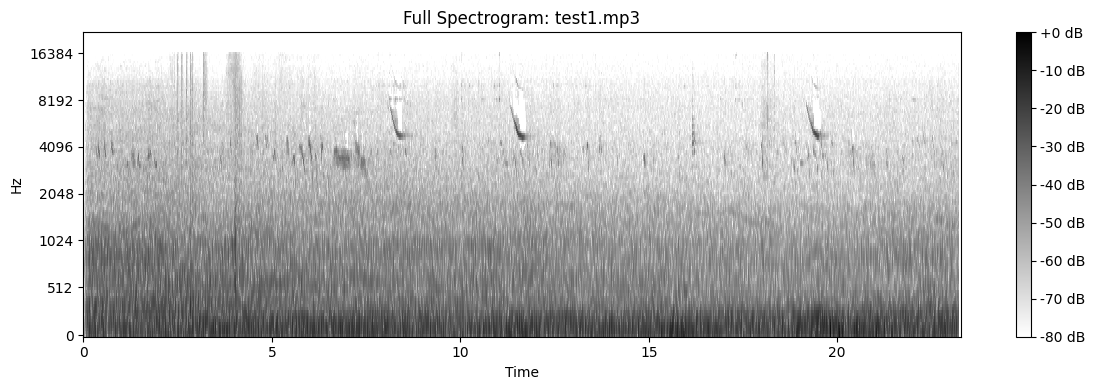

File: test2.mp3, Duration: 5.25 seconds, Sample rate: 44100


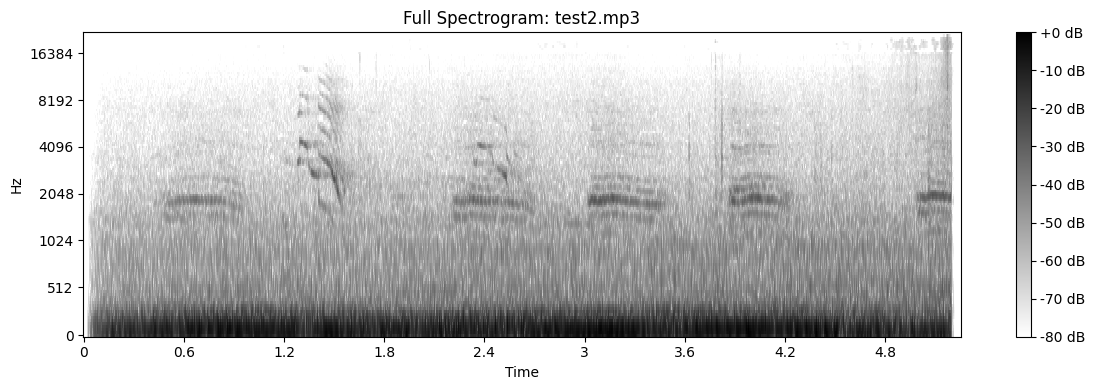

File: test3.mp3, Duration: 15.88 seconds, Sample rate: 44100


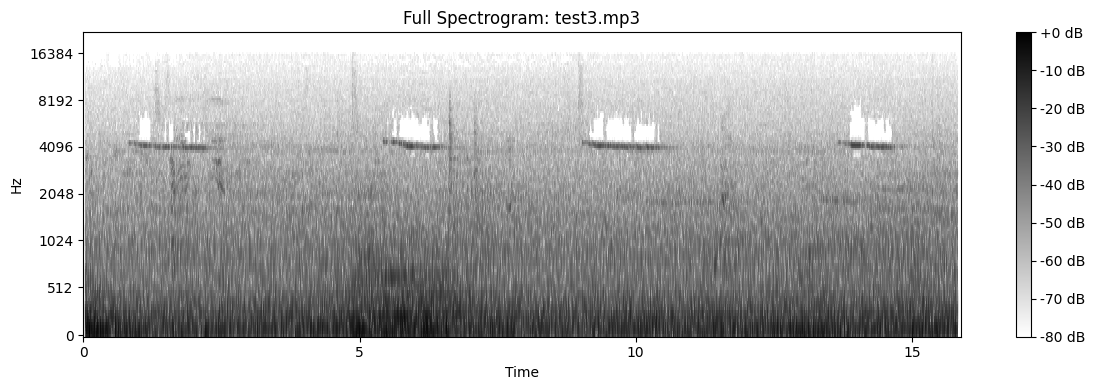

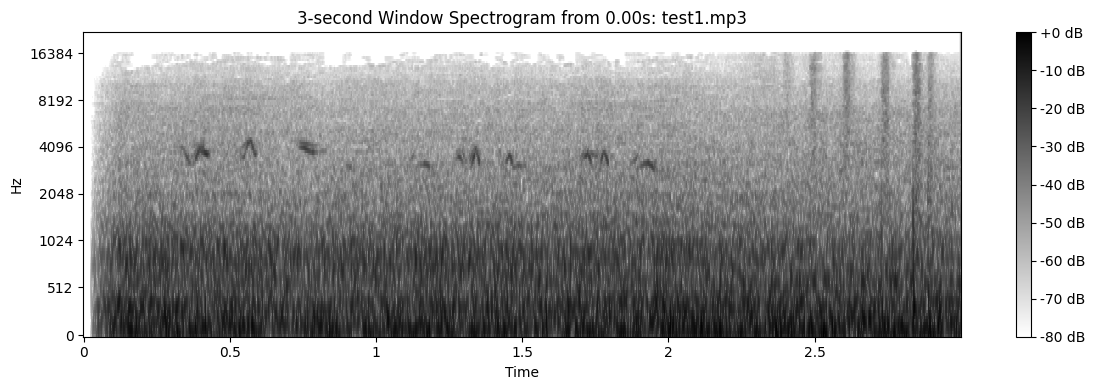

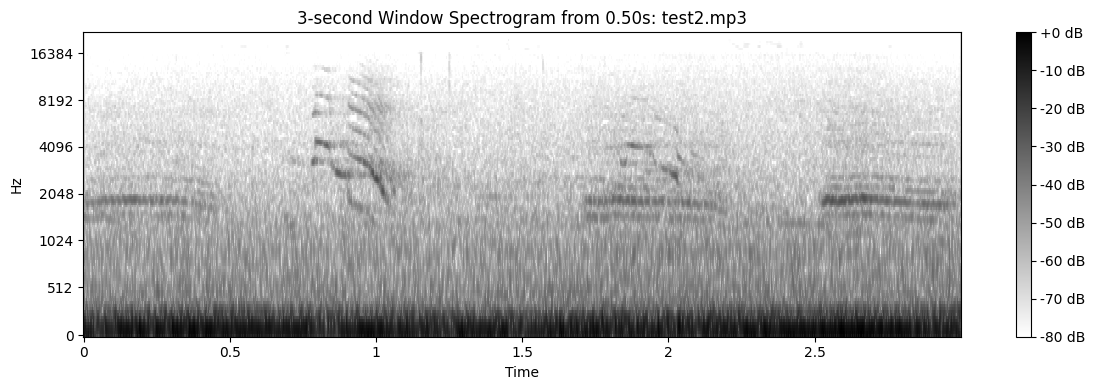

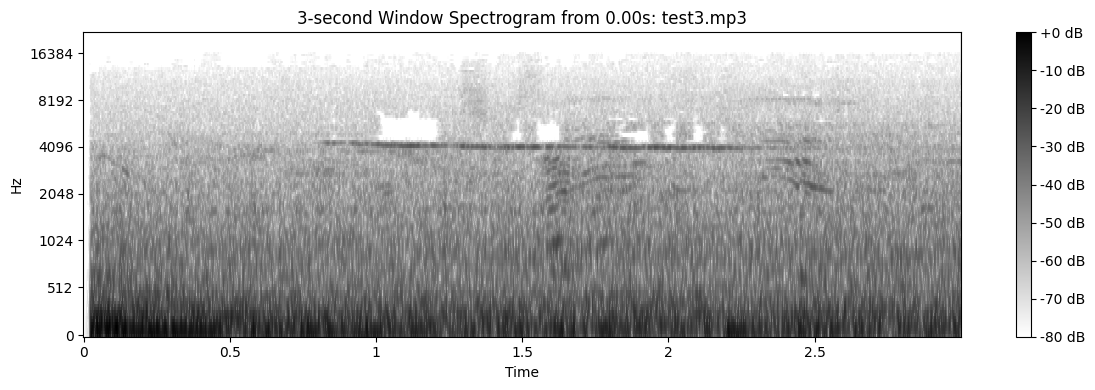

In [64]:
# Select 3 second window with audio present
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

audio_files = ['test1.mp3', 'test2.mp3', 'test3.mp3']

hop_length = 128
win_length = 512

def plot_spectrogram(y, sr, hop_length, win_length, title='Spectrogram'):
    spec = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length, win_length=win_length)
    spec_db = librosa.power_to_db(spec, ref=np.max)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='gray_r')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Load and plot full audio files
full_audio_data = [] 

for file in audio_files:
    y, sr = librosa.load(file, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    print(f"File: {file}, Duration: {duration:.2f} seconds, Sample rate: {sr}")
    
    plot_spectrogram(y, sr, hop_length, win_length, title=f'Full Spectrogram: {file}')
    
    full_audio_data.append((y, sr, duration))

# Plot the specified 3-second windows from the full audio
start_times = [0.0, 0.5, 0.0] 
for (y, sr, duration), start_time, file in zip(full_audio_data, start_times, audio_files):
    if start_time < 0 or start_time > duration - 3:
        print(f"Invalid start time {start_time} for file {file}, using 0 seconds instead.")
        start_time = 0

    start_sample = int(start_time * sr)
    end_sample = start_sample + int(3 * sr)
    y_segment = y[start_sample:end_sample]

    plot_spectrogram(y_segment, sr, hop_length, win_length, title=f'3-second Window Spectrogram from {start_time:.2f}s: {file}')


In [65]:
### Saving test spectrograms
import librosa
import numpy as np
import h5py

test_files = ['test1.mp3', 'test2.mp3', 'test3.mp3']
start_times = [0.0, 0.5, 0.0] 
duration_window = 3 

hop_length = 128
win_length = 512
n_mels = 128
n_frames = 517 

# Initialize blank arraynfor spectrograms (frequency, time, samples)
test_specs = np.zeros((n_mels, n_frames, len(test_files)))

for i, (fname, start) in enumerate(zip(test_files, start_times)):
    y, sr = librosa.load(fname, sr=None)
    
    # Calculate sample indices for the window
    start_sample = int(start * sr)
    end_sample = start_sample + int(duration_window * sr)
    
    # Extract the 3-second window from the audio
    y_window = y[start_sample:end_sample]
    
    # Compute mel spectrogram
    spec = librosa.feature.melspectrogram(y=y_window, sr=sr, hop_length=hop_length, win_length=win_length, n_mels=n_mels)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    
    # If spectrogram has fewer frames than n_frames, use minimum value
    if spec_db.shape[1] < n_frames:
        pad_width = n_frames - spec_db.shape[1]
        spec_db = np.pad(spec_db, ((0,0),(0,pad_width)), mode='constant', constant_values=spec_db.min())
    else:
        spec_db = spec_db[:, :n_frames] 
    
    test_specs[:, :, i] = spec_db

# Save spectrograms to HDF5
hdfname = 'test_spectrograms.hdf5'
with h5py.File(hdfname, 'w') as f:
    f.create_dataset('test', data=test_specs)
    print(f"Saved spectrograms to {hdfname}")

# Verify saved shape
with h5py.File(hdfname, 'r') as f:
    dset = f['test']
    print(f"Dataset shape: {dset.shape}")


Saved spectrograms to test_spectrograms.hdf5
Dataset shape: (128, 517, 3)


In [66]:
### Predict on test data using Multi-class Model
# Load the test spectrograms
with h5py.File('test_spectrograms.hdf5', 'r') as f:
    test_data = f['test'][:]  # Shape: (128, 517, 3)

# Reorder to CNN input shape: (samples, frequency, time)
X_test_external = np.transpose(test_data, (2,0,1))  # (3, 128, 517)

# predict on test data
pred_probs = model.predict(X_test_external)

# get predicted classes
pred_classes = np.argmax(pred_probs, axis=1)

# Map to species names
species_list = ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 
                'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']

# predicted species
predicted_species = [species_list[i] for i in pred_classes]
predicted_species

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


['rewbla', 'amerob', 'amerob']

In [67]:
# confidence for predictions
import pandas as pd
pd.DataFrame(pred_probs, columns=species_list, index=['test1', 'test2', 'test3'])

,amecro,amerob,bewwre,bkcchi,daejun,houfin,houspa,norfli,rewbla,sonspa,spotow,whcspa
test1,0.044378,0.153599,0.000313,0.013943,0.009192,0.042343,0.108391,0.023151,0.497739,0.001190,0.010914,0.094846
test2,0.043791,0.639221,0.000670,0.000686,0.002408,0.001600,0.014820,0.035072,0.249656,0.001870,0.005684,0.004523
test3,0.013754,0.828255,0.000114,0.001331,0.000205,0.009340,0.010370,0.118077,0.016969,0.000302,0.000182,0.001101


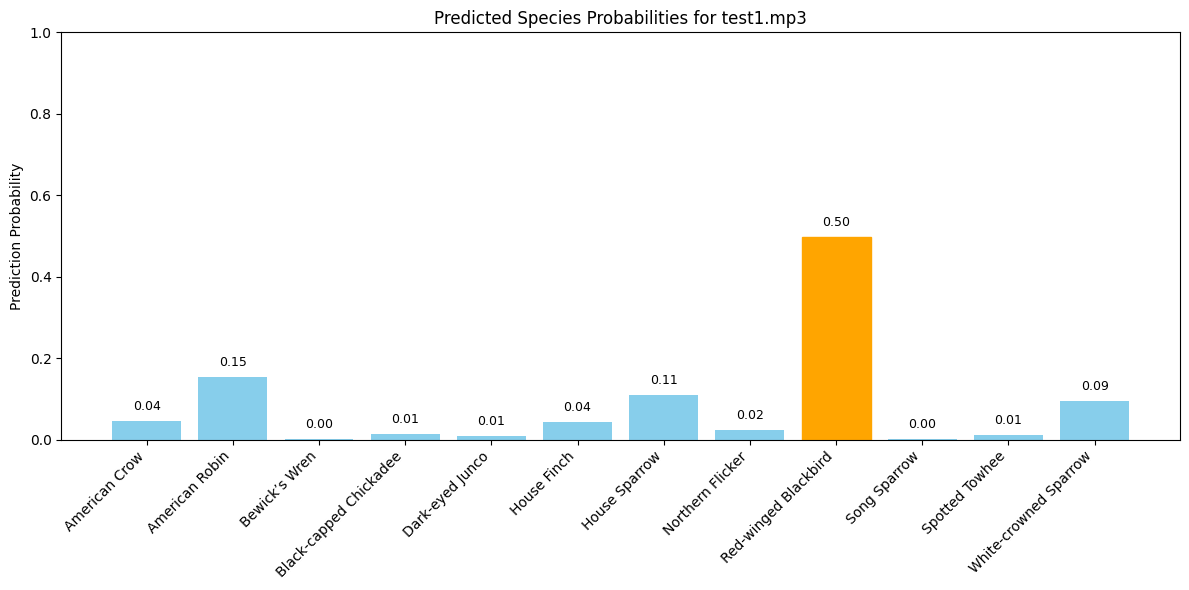

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Full species names
full_labels = ['American Crow', 'American Robin', 'Bewick’s Wren', 'Black-capped Chickadee',
               'Dark-eyed Junco', 'House Finch', 'House Sparrow', 'Northern Flicker',
               'Red-winged Blackbird', 'Song Sparrow', 'Spotted Towhee', 'White-crowned Sparrow']

# Probabilities for test1
test1_probs = pred_probs[0]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(full_labels, test1_probs, color='skyblue')
plt.ylabel("Prediction Probability")
plt.title("Predicted Species Probabilities for test1.mp3")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Highlight the most probable class in orange
bars[np.argmax(test1_probs)].set_color('orange')

# Annotate each bar with the probability
for bar, prob in zip(bars, test1_probs):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.02,
             f'{prob:.2f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


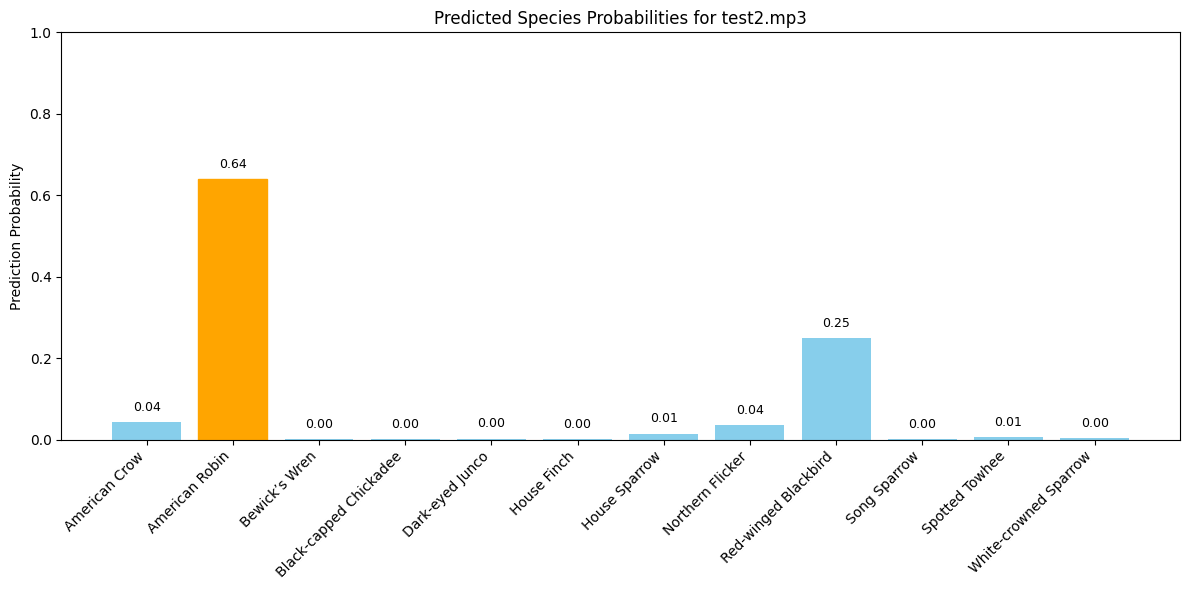

In [108]:
# Full species names
full_labels = ['American Crow', 'American Robin', 'Bewick’s Wren', 'Black-capped Chickadee',
               'Dark-eyed Junco', 'House Finch', 'House Sparrow', 'Northern Flicker',
               'Red-winged Blackbird', 'Song Sparrow', 'Spotted Towhee', 'White-crowned Sparrow']

# Probabilities for test2
test2_probs = pred_probs[1]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(full_labels, test2_probs, color='skyblue')
plt.ylabel("Prediction Probability")
plt.title("Predicted Species Probabilities for test2.mp3")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Highlight the most probable class in orange
bars[np.argmax(test2_probs)].set_color('orange')

# Annotate each bar with the probability
for bar, prob in zip(bars, test2_probs):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.02,
             f'{prob:.2f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


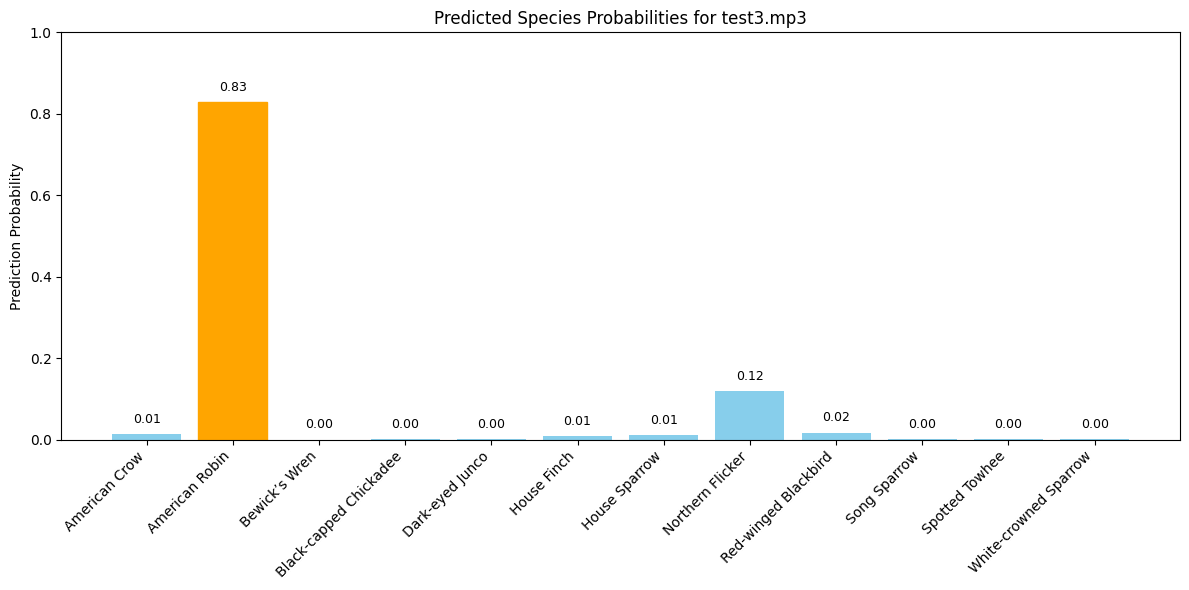

In [109]:
# Full bird species labels
full_labels = ['American Crow', 'American Robin', 'Bewick’s Wren', 'Black-capped Chickadee',
               'Dark-eyed Junco', 'House Finch', 'House Sparrow', 'Northern Flicker',
               'Red-winged Blackbird', 'Song Sparrow', 'Spotted Towhee', 'White-crowned Sparrow']

# Probabilities for test3
test3_probs = pred_probs[2]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(full_labels, test3_probs, color='skyblue')
plt.ylabel("Prediction Probability")
plt.title("Predicted Species Probabilities for test3.mp3")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Highlight most probable class in orange
bars[np.argmax(test3_probs)].set_color('orange')

# Annotate each bar with the probability
for bar, prob in zip(bars, test3_probs):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.02,
             f'{prob:.2f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
